In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Função que gera as coordenadas dos APs
def distribuir_APs(num_aps):
    '''Distributes Access Points (APs) evenly within a square area.
    
    Parameters:
    num_aps (int): The number of APs to distribute. Must be a perfect square.
    
    Returns:
    np.array: An array of coordinates for the APs, or None if num_aps is not a perfect square.'''
    
    if num_aps not in [1, 4, 9, 16, 25, 36, 49, 64, 100]:
        return None

    tamanho_quadrado = 1000
    lado_quadrado = int(np.sqrt(num_aps))

    tamanho_celula = tamanho_quadrado // lado_quadrado

    # Criar coordenadas usando meshgrid
    x, y = np.meshgrid(np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula),
                      np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula))

    coordenadas_APs = np.column_stack((x.ravel(), y.ravel()))

    return coordenadas_APs

In [34]:
#Função que transforma Linear para dB
def lin2db(x):
    return 10 * np.log10(x)

#Função que transforma dB para Linear
def db2lin(x):
    return 10 ** (x / 10)

In [35]:
# Função que gera a distância entre a UE e a AP
def dAPUE(x_coord, y_coord, ap_coord):
  '''Calculate the Euclidean distance between a user equipment (UE) and an access point (AP).
    
    Parameters:
    ue_coords (tuple): A tuple (x_coord, y_coord) representing the coordinates of the UE.
    ap_coords (np.array): An array containing the coordinates of the APs.
    
    Returns:
    float: The Euclidean distance between the UE and the AP.
  '''
  dAPUE = np.linalg.norm(np.array([x_coord, y_coord]) - ap_coord)
  return dAPUE

In [36]:
#Função que define o shadowing e muda ele a cada 10 passos
def find_shadowing(passos):
    '''Generate shadowing values that change every 10 steps based on a log-normal distribution.

    Parameters:
    num_steps (int): The number of steps for which shadowing values are needed.

    Returns:
    list: A list of shading values for each step, changing every 10 steps.'''
    shadowing = []

    valor_atual = np.random.lognormal(0, 2)  # Inicializa o shadowing com sigma = 2 [LINEAR]
    for i in range(passos):
        if (i) % 100 == 0 and i != 0:  # Atualiza o shadowing a cada 10 passos, exceto no passo 0
            valor_atual = np.random.lognormal(0, 2)
        shadowing.append(valor_atual)  # Adiciona o valor atual à lista
    return shadowing 

In [37]:
# Função que calcula o path gain
def find_path_gain(dist, shadowing):
    ''' Calculate the path gain for a given distance and shadowing value.

    Parameters:
    distance (float): The distance from the transmitter to the receiver.
    shadowing (float): The shadowing effect value, typically a multiplier derived from a log-normal distribution.

    Returns:
    float: The path gain calculated using the given distance and shadowing effects.'''
    k = 1e-4
    n = 4
    path_gain_result = shadowing * (k / ((dist) ** n)) #Obtem o path_gain local de cada AP

    return path_gain_result # [LINEAR]

In [38]:
# Função que calcula a potência recebida
def find_pot_rec(pot_trans, dist, d_0, shadowing):
    ''''Calculate the received power from a transmitter to a receiver based on the distance, 
    transmission power, and shadowing effect.

    Parameters:
    pot_trans (float): The transmission power.
    dist (float): The distance from the transmitter to the receiver.
    d_0 (float): The threshold distance below which the power calculation does not occur.
    shadowing (float): The shadowing effect, modifying the power based on environmental factors.

    Returns:
    float: The received power if distance is above the threshold; otherwise, returns zero.'''
    k = 1e-4
    n = 4
    if dist >= d_0:
        pot_rec_result = shadowing * (pot_trans * (k / ((dist) ** n))) #Obtem a potência recebida de cada AP

    return pot_rec_result # [LINEAR]

In [39]:
def calculate_snr(B_t, p_t, d_0, K_0, M, N, passos, shadowing, cluster):
    '''Calculate the Signal-to-Noise Ratio (SNR) as a user equipment moves through a given path.

    Parameters:
    B_t (float): Total bandwidth.
    p_t (float): Transmit power.
    d_0 (float): Minimum distance for power calculation.
    K_0 (float): Noise figure (or power of the noise).
    M (int): Number of Access Points (APs).
    N (int): Number of channels.
    passos (int): Number of steps in the simulation.
    shadowing (list): List of shadowing values affecting signal quality.
    cluster (int): Number of APs considered in the calculation of SNR.

    Returns:
    list: A list of SNR values for each step in the simulation.'''
    #UE irá se mover metro por metro e irá iniciar do ponto (0, 500) e irá até (1000, 500)
    x_coord = np.zeros(passos)
    y_coord = np.zeros(passos)
    for passo in range (passos):
        x_coord[passo] = passo/10
        y_coord[passo] = 500 

    #Definindo váriaveis locais
    ap_coord = distribuir_APs(M)
    power_noise = K_0*(B_t/N)
    distance = np.zeros(M)
    path_gain = np.zeros(M)
    power_rec = np.zeros(passos)
    snr = np.zeros(cluster)
    snr_final = []
    
    #Fazendo o Handover
    for passo in range(passos):
        for index_AP in range(M):
            distance[index_AP] = dAPUE(x_coord[passo], y_coord[passo], ap_coord[index_AP])
            path_gain[index_AP] = find_path_gain(distance[index_AP], shadowing[passo])
        max_index = np.argsort(path_gain)[-cluster:][::-1]
        for clust in range(len(max_index) ):
            indice = max_index[clust]
            power_rec[clust] = find_pot_rec(p_t, distance[indice], d_0, shadowing[passo])
            snr[clust] = power_rec[clust]/power_noise
        snr_sum = np.sum(snr)
        snr_final.append(snr_sum)
    return snr_final

In [40]:
def max_cluster_number (M, passos, shadowing):
    '''Determines the maximum number of APs in a cluster based on path gain.
    
    Parameters:
    M (int): Number of Access Points (APs).
    passos (int): Number of simulation steps (distance steps).
    shadowing (list): List of shadowing values for each step.
    
    Returns:
    int: The step index where path gains stop increasing consistently.'''
    x_coord = np.zeros(passos)
    y_coord = np.zeros(passos)
    for passo in range (passos):
        x_coord[passo] = passo/10
        y_coord[passo] = 500 

    #Definindo váriaveis locais
    ap_coord = distribuir_APs(M)
    distance = np.zeros(M)
    path_gain = np.zeros(M)
    ci = 0
    
    #Fazendo o Handover
    for passo in range(passos):
        for index_AP in range(M):
            distance[index_AP] = dAPUE(x_coord[passo], y_coord[passo], ap_coord[index_AP])
            path_gain[index_AP] = find_path_gain(distance[index_AP], shadowing[passo])
        while ci < len(path_gain) and path_gain[ci] <= path_gain[ci+1]:
            ci += 1

    return ci

In [41]:
def calculate_capacity(B_t, p_t, d_0, K, M, N, passos, shadowing, cluster):
    ''' Calculates the channel capacity over a number of steps in a simulation.

    Parameters:
    B_t (float): Total bandwidth available.
    p_t (float): Transmit power of the source.
    d_0 (float): Reference distance for the path loss calculations.
    K (float): Noise figure or noise power.
    M (int): Number of Access Points.
    N (int): Number of channels.
    passos (int): Number of steps or points in the simulation.
    shadowing (list): Shadowing effects at each step.
    cluster (int): Number of APs considered in the cluster for SNR calculations.

    Returns:
    np.array: An array of capacity values for each step in the simulation.'''
    
    snr = calculate_snr(B_t, p_t, d_0, K, M, N, passos, shadowing, cluster)
    B_c = B_t/N
    capacity = np.zeros(passos)
    for i in range(passos):
        capacity[i] = B_c * np.log2(1 + snr[i])
        
    return capacity


In [52]:
B_t, p_t, d_0, K_0 = 100e6, 1e3, 1, 1e-17 # Em MHz, mW, metros, mW/Hz respectivamente
ap, ue, channel = 100, 1, 1
passos = 10000 # Definido já que a UE irá se mover metro por metro
shadow = find_shadowing(passos) # Definindo o shadowing
passos_array = np.arange(passos)

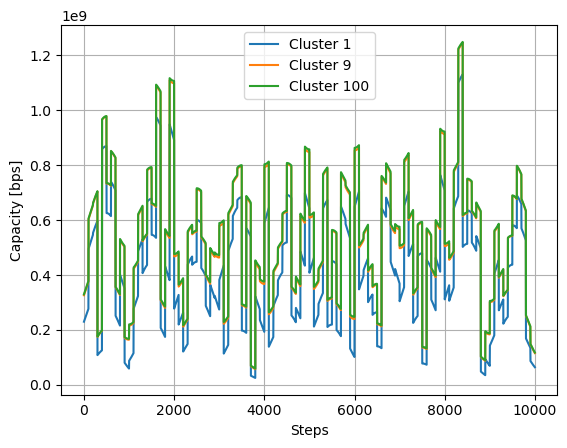

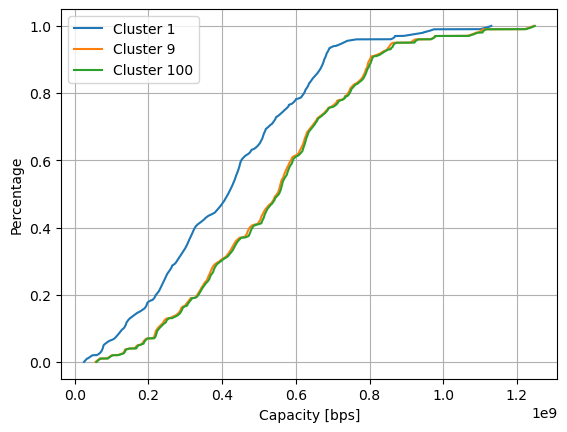

In [53]:
cluster1, cluster2, cluster3 = 1, 9, 100 # Informa com quantas APs a UE irá se comunicar  (Handover)
capacity1 = calculate_capacity(B_t, p_t, d_0, K_0, ap, channel, passos, shadow, cluster1)
capacity2 = calculate_capacity(B_t, p_t, d_0, K_0, ap, channel, passos, shadow, cluster2)
capacity3 = calculate_capacity(B_t, p_t, d_0, K_0, ap, channel, passos, shadow, cluster3)
passos_array = np.arange(passos) 
cdf_capacity1 = np.sort(capacity1)
cdf_capacity2 = np.sort(capacity2)
cdf_capacity3 = np.sort(capacity3)

# Plotando a Capacidade pela distância percorrida
plt.plot(passos_array, capacity1, label=f'Cluster {cluster1}')
plt.plot(passos_array, capacity2, label=f'Cluster {cluster2}')
plt.plot(passos_array, capacity3, label=f'Cluster {cluster3}')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Capacity [bps]')
#plt.title('Capacity of Cell-Free Network')
plt.grid()
#plt.savefig('capacity2.png')
plt.show()

# Plotando a CDF da Capacidade
plt.plot(cdf_capacity1, np.arange(0, len(capacity1)) / len(capacity1), label=f'Cluster {cluster1}')
plt.plot(cdf_capacity2, np.arange(0, len(capacity2)) / len(capacity2), label=f'Cluster {cluster2}')
plt.plot(cdf_capacity3, np.arange(0, len(capacity2)) / len(capacity2), label=f'Cluster {cluster3}')
plt.legend()
plt.xlabel('Capacity [bps]')
plt.ylabel('Percentage')
#plt.title('Capacity CDF of Cell-Free Network')
plt.grid()
plt.savefig('cdf_capacity.pdf')
plt.show()

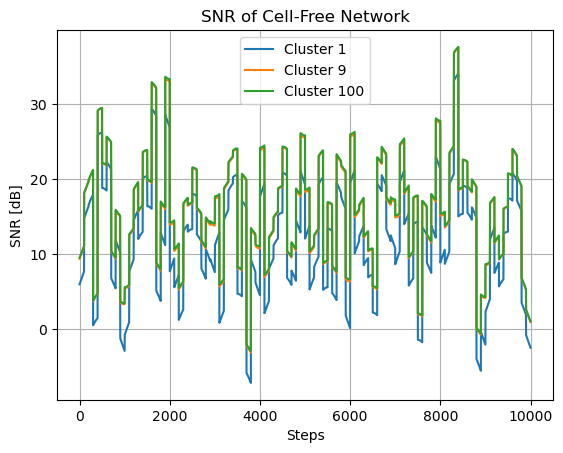

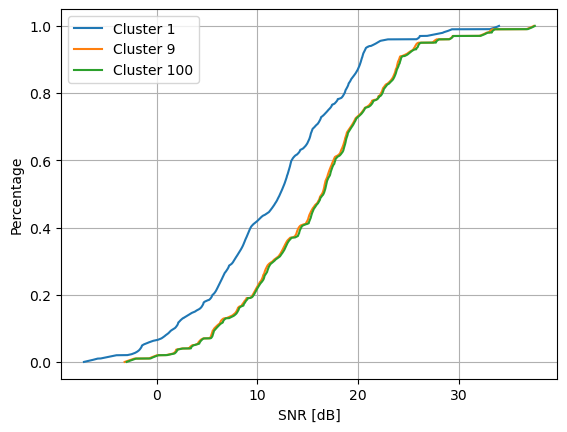

In [54]:
cluster1, cluster2, cluster3 = 1, 9, 100 # Informa com quantas APs a UE irá se comunicar  (Handover)
snr1 = calculate_snr(B_t, p_t, d_0, K_0, ap, channel, passos, shadow, cluster1)
snr2 = calculate_snr(B_t, p_t, d_0, K_0, ap, channel, passos, shadow, cluster2)
snr3 = calculate_snr(B_t, p_t, d_0, K_0, ap, channel, passos, shadow, cluster3)
snr1 = lin2db(snr1)
snr2 = lin2db(snr2)
snr3 = lin2db(snr3)
cdf_snr1 = np.sort(snr1)
cdf_snr2 = np.sort(snr2)
cdf_snr3 = np.sort(snr3)

# Plotando a Capacidade pela distância percorrida
plt.plot(passos_array, snr1, label=f'Cluster {cluster1}')
plt.plot(passos_array, snr2, label=f'Cluster {cluster2}')
plt.plot(passos_array, snr3, label=f'Cluster {cluster3}')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('SNR [dB]')
plt.title('SNR of Cell-Free Network')
plt.grid()
#plt.savefig('snr.png')
plt.show()

# Plotando a CDF da Capacidade
plt.plot(cdf_snr1, np.arange(0, len(capacity1)) / len(capacity1), label=f'Cluster {cluster1}')
plt.plot(cdf_snr2, np.arange(0, len(capacity1)) / len(capacity1), label=f'Cluster {cluster2}')
plt.plot(cdf_snr3, np.arange(0, len(capacity1)) / len(capacity1), label=f'Cluster {cluster3}')
plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel('Percentage')
#plt.title('SNR CDF of Cell-Free Network')
plt.grid()
plt.savefig('cdf_snr.pdf')
plt.show()

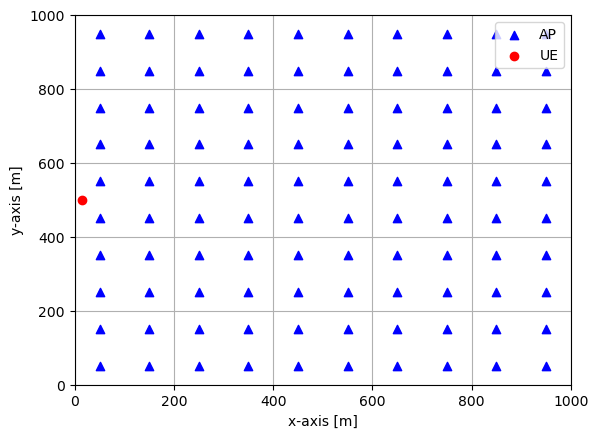

In [45]:
'''import matplotlib.pyplot as plt

# Suponha que distribuir_APs() retorne uma lista de coordenadas das APs
aps = distribuir_APs(100)

# Coordenadas iniciais da UE
ue = (15, 500)

# Cria um novo gráfico
fig, ax = plt.subplots()

# Plota as APs como triângulos azuis
ax.scatter(*zip(*aps), color='blue', marker='^', label='AP')

# Plota a posição inicial da UE como uma bola vermelha
ax.scatter(*ue, color='red', label='UE')

# Adiciona a legenda
ax.legend()

# Define os limites do gráfico
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)
#plt.title('Position of APs and UE')
plt.xlabel('x-axis [m]')
plt.ylabel('y-axis [m]')
plt.grid()
plt.savefig('position.pdf')
# Mostra o gráfico
plt.show()'''

In [46]:
a = max_cluster_number(100, passos, shadow)
print(a)

9


In [47]:
'''def plot_pathgain(B_t, p_t, d_0, K_0, M, N, passos, shadowing):
    #UE irá se mover metro por metro e irá iniciar do ponto (0, 500) e irá até (1000, 500)
    x_coord = np.zeros(passos)
    y_coord = np.zeros(passos)
    for passo in range (passos):
        x_coord[passo] = (passo+1)
        y_coord[passo] = 500 

    #Definindo váriaveis locais
    ap_coord = distribuir_APs(M)
    power_noise = K_0*(B_t/N)
    distance = np.zeros(M)
    path_gain = np.zeros(M)
    power_rec = np.zeros(passos)
    
    #Fazendo o Handover
    for passo in range(passos):
        for index_AP in range(M):
            distance[index_AP] = dAPUE(x_coord[passo], y_coord[passo], ap_coord[index_AP])
            path_gain[index_AP] = find_path_gain(distance[index_AP], shadowing[passo])
       
    return path_gain'''

'def plot_pathgain(B_t, p_t, d_0, K_0, M, N, passos, shadowing):\n    #UE irá se mover metro por metro e irá iniciar do ponto (0, 500) e irá até (1000, 500)\n    x_coord = np.zeros(passos)\n    y_coord = np.zeros(passos)\n    for passo in range (passos):\n        x_coord[passo] = (passo+1)\n        y_coord[passo] = 500 \n\n    #Definindo váriaveis locais\n    ap_coord = distribuir_APs(M)\n    power_noise = K_0*(B_t/N)\n    distance = np.zeros(M)\n    path_gain = np.zeros(M)\n    power_rec = np.zeros(passos)\n    \n    #Fazendo o Handover\n    for passo in range(passos):\n        for index_AP in range(M):\n            distance[index_AP] = dAPUE(x_coord[passo], y_coord[passo], ap_coord[index_AP])\n            path_gain[index_AP] = find_path_gain(distance[index_AP], shadowing[passo])\n       \n    return path_gain'

In [48]:
'''import matplotlib.pyplot as plt
import numpy as np
import imageio

# Suponha que distribuir_APs() retorne uma lista de coordenadas das APs
aps = distribuir_APs(100)

# Cria uma lista para armazenar os quadros
frames = []

# Calcula as coordenadas do usuário uma vez antes do loop
x_coord = np.arange(1, passos + 1)
y_coord = np.full(passos, 500)

for passo in range(passos):
    # Cria um novo gráfico
    fig, ax = plt.subplots()

    # Plota as APs como triângulos azuis apontando para cima
    ax.scatter(*zip(*aps), color='blue', marker='^', label='triângulo azul - AP')

    # Plota a posição atual do usuário como uma bola vermelha
    ax.scatter(x_coord[passo], y_coord[passo], color='red', label='bola vermelha - UE em movimento')

    # Adiciona a legenda
    ax.legend()

    # Salva o gráfico como uma imagem e adiciona à lista de quadros
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

    plt.close(fig)

# Cria um GIF a partir dos quadros com 4 vezes a velocidade original
imageio.mimsave('movimento.gif', frames, fps=150)'''

"import matplotlib.pyplot as plt\nimport numpy as np\nimport imageio\n\n# Suponha que distribuir_APs() retorne uma lista de coordenadas das APs\naps = distribuir_APs(100)\n\n# Cria uma lista para armazenar os quadros\nframes = []\n\n# Calcula as coordenadas do usuário uma vez antes do loop\nx_coord = np.arange(1, passos + 1)\ny_coord = np.full(passos, 500)\n\nfor passo in range(passos):\n    # Cria um novo gráfico\n    fig, ax = plt.subplots()\n\n    # Plota as APs como triângulos azuis apontando para cima\n    ax.scatter(*zip(*aps), color='blue', marker='^', label='triângulo azul - AP')\n\n    # Plota a posição atual do usuário como uma bola vermelha\n    ax.scatter(x_coord[passo], y_coord[passo], color='red', label='bola vermelha - UE em movimento')\n\n    # Adiciona a legenda\n    ax.legend()\n\n    # Salva o gráfico como uma imagem e adiciona à lista de quadros\n    fig.canvas.draw()\n    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')\n    image = image.reshape(fig